# The curse: dealing with high-dimensional data [1]

This series of posts is inspired by a lecture by Killian Weinberger (Cornell University) that is available on YouTube, specifically lecture 4 in this [series](https://youtu.be/MrLPzBxG95I). In this lecture, he talks about the curse of dimensionality. What got me thinking was that how he explained that k-nearest neighbours (kNN) classifiers can still work in high-dimensional cases if the data lies on a manifold that is locally low-dimensional. Something else I have been thinking about earlier is that the curse of dimensionality is always explained with completely random data sets. So, I have been curious to see what the effect is on non-random data.

Let's load the packages we need first:

In [1]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree as BallTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
random.seed(11)

## Dot-and-Shell: 2D case

To study the curse of dimensionality, we simulate data belonging to two classes. We start with a two-dimensional data set. Data points in the first class are distributed uniformly within a circular area and are shown in blue below. Data points in the second class are distributed uniformly in a band surrounding the blue data points. We simulate the same number of points in both classes. These points are easy to separate by means of a circular boundary.

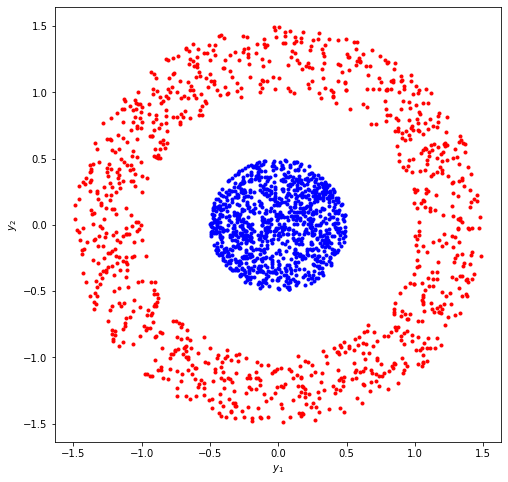

In [2]:
M = 1024
r0 =0
r1 =1

def fDataGeneration(M,N,R):
    X = np.random.normal(0,1,[M,N])
    X = np.divide(X,np.sqrt(np.sum(X**2,axis=1)[:,None]))
    xConv = False
    counter=0
    while (counter<11 and xConv==False):
        counter += 1
        U = (R**N+((R+1/2)**N-R**N)*np.random.uniform(0,1,[M,1]))**(1/float(N))
        if ~np.any(np.isnan(U.flatten())):
            xConv = True
            Y = X*U
            pass
        else:
            print(counter)
        
    return Y


N = 2
Y0 = fDataGeneration(M,N,R=r0)
Y1 = fDataGeneration(M,N,R=r1)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[8,8])
ax.plot(Y0[:,0],Y0[:,1],'b.')
ax.plot(Y1[:,0],Y1[:,1],'r.')
ax.set_xlabel('$y_1$');
ax.set_ylabel('$y_2$');

## Dot-and-Shell+: 3D case

The  previous example can be repeated in 3D. Again, there are two classes with equal numbers of data points. These points can be separated now by means of a spherical boundary. The next figure shows points in 3D for this case:

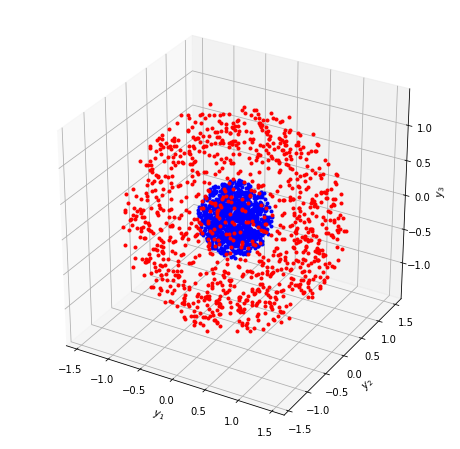

In [3]:

N = 3
Y0 = fDataGeneration(M,N,R=r0)
Y1 = fDataGeneration(M,N,R=r1)


fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[8,8])
ax = plt.axes(projection='3d')
ax.plot3D(Y0[:,0],Y0[:,1],Y0[:,2], 'b.')
ax.plot3D(Y1[:,0],Y1[:,1],Y1[:,2], 'r.')
ax.set_xlabel('$y_1$');
ax.set_ylabel('$y_2$');
ax.set_zlabel('$y_3$');

## Dot-and-Shell++: $N$-D case

The  previous example can be repeated in any dimensions. As before, there are two classes with equal numbers of data points. These points can again be separated easily. In this case, this boundary can be tought of as a hyperspherical   object. The graph shows the first 2 coordinates in the 42D case: 

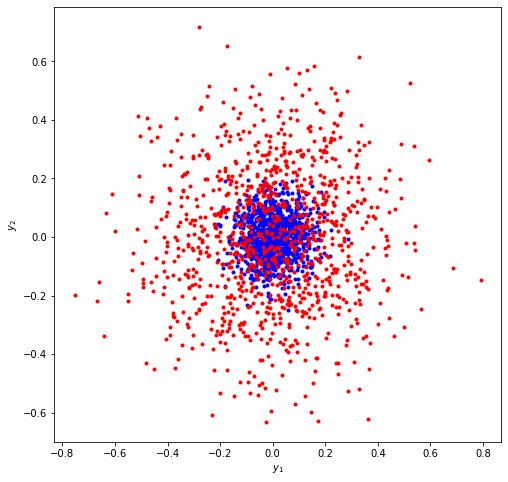

In [4]:
N = 42
Y0 = fDataGeneration(M,N,R=r0)
Y1 = fDataGeneration(M,N,R=r1)

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[8,8])
ax.plot(Y0[:,0],Y0[:,1],'b.')
ax.plot(Y1[:,0],Y1[:,1],'r.')
ax.set_xlabel('$y_1$');
ax.set_ylabel('$y_2$');

### Why I like example++

I like the high-dimensional example for many reasons, some of which are:
* We can get some intuition about the data in the two classes by mapping our intuitions in 2D and 3D to $N$-D (even if some intuitions might be misleading).
* The distributions associated with both classes exhibit the same symmetry no matter the number of dimensions
* One data set (blue points) is distributed around a point, meaning that the points can be locally embedded in a 0D-space (a point), whereas the other data set (red points) is distributed around a hyper-spherical shell, with local geometry being $N-1$-dimensional. For example, the geometry of a circle in 2D can be described locally with a tangent line, the geometry of a sphere can be described locally with a tangent plane.

## Visualizing the curse of dimensionality

We will now inspect the empirical distribution of several distances:

* The distances of the blue points to their closest neighbour with the set of blue points (blue full line below)

* The distances of the red points to their closest neighbour with the set of red points (red full line below)

* The distances of the blue points to their closest neighbour with the set of red points (blue dashed line below)

* The distances of the red points to their closest neighbour with the set of blue points (red dashed line below)

We show the empirical cumulative density functions (ECDFs) for the 2D case first:

In [5]:

N = 2
Y0 = fDataGeneration(M,N,R=r0)
Y1 = fDataGeneration(M,N,R=r1)
BT0 = BallTree(Y0, leaf_size=5, p=2)
BT1 = BallTree(Y1, leaf_size=5, p=2)

nn_dist00 =np.sort(BT0.query(Y0, 2)[0][:, 1]) # Index=1. Take sample closest to query sample, except itself
nn_dist11 =np.sort(BT1.query(Y1, 2)[0][:, 1]) # Index=1. Take sample closest to query sample, except itself
nn_dist10 =np.sort(BT0.query(Y1, 2)[0][:, 0]) # Index=0. Take sample closest to query sample
nn_dist01 =np.sort(BT1.query(Y0, 2)[0][:, 0]) # Index=0. Take sample closest to query sample


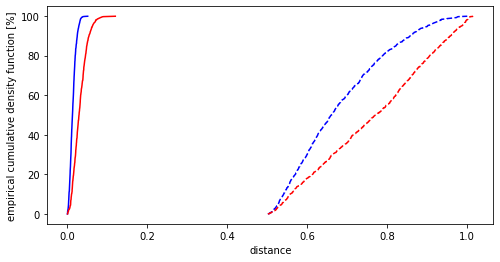

In [6]:
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[8,4])
ax.plot(nn_dist00,np.arange(M)*1/M*100, 'b-')
ax.plot(nn_dist11,np.arange(M)*1/M*100,'r-')
ax.plot(nn_dist01,np.arange(M)*1/M*100,'b--')
ax.plot(nn_dist10,np.arange(M)*1/M*100,'r--')
ax.set_xlabel('distance');
ax.set_ylabel('empirical cumulative density function [%]');

One can see that the closest neigbours within the same class are fairly close where the closest neigbours in the opposite class tend to be far. A key feature of the simulate data is that the smallest feasible distance between the two data classes equals 0.5. The next graph shows the same cumulative densities for the 3D case:

In [7]:

N = 3
Y0 = fDataGeneration(M,N,R=r0)
Y1 = fDataGeneration(M,N,R=r1)
BT0 = BallTree(Y0, leaf_size=5, p=2)
BT1 = BallTree(Y1, leaf_size=5, p=2)

nn_dist00 =np.sort(BT0.query(Y0, 2)[0][:, 1])
nn_dist11 =np.sort(BT1.query(Y1, 2)[0][:, 1])
nn_dist10 =np.sort(BT0.query(Y1, 2)[0][:, 0])
nn_dist01 =np.sort(BT1.query(Y0, 2)[0][:, 0])


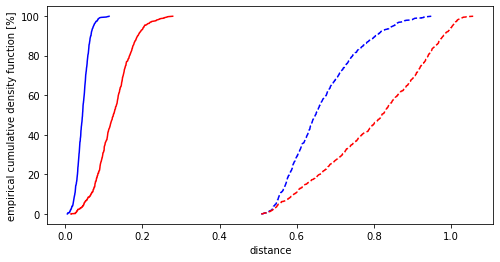

In [8]:
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[8,4])
ax.plot(nn_dist00,np.arange(M)*1/M*100, 'b-')
ax.plot(nn_dist11,np.arange(M)*1/M*100,'r-')
ax.plot(nn_dist01,np.arange(M)*1/M*100,'b--')
ax.plot(nn_dist10,np.arange(M)*1/M*100,'r--')
ax.set_xlabel('distance');
ax.set_ylabel('empirical cumulative density function [%]');

Qualitatively speaking, this figure is very similar to the previous one. It shows that the within-class distances are small relative to the out-of-class distances. Now let's look at these  cumulative densities in the 42-dimensional case:

In [9]:
N = 42
Y0 = fDataGeneration(M,N,R=r0)
Y1 = fDataGeneration(M,N,R=r1)
BT0 = BallTree(Y0, leaf_size=5, p=2)
BT1 = BallTree(Y1, leaf_size=5, p=2)

nn_dist00 =np.sort(BT0.query(Y0, 2)[0][:, 1])
nn_dist11 =np.sort(BT1.query(Y1, 2)[0][:, 1])
nn_dist10 =np.sort(BT0.query(Y1, 2)[0][:, 0])
nn_dist01 =np.sort(BT1.query(Y0, 2)[0][:, 0])


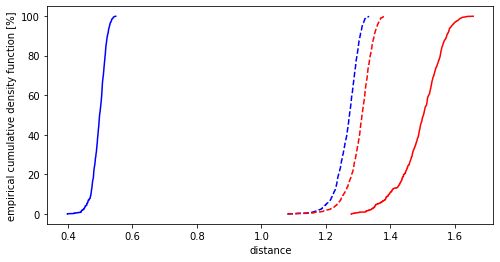

In [10]:
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=[8,4])
ax.plot(nn_dist00,np.arange(M)*1/M*100, 'b-')
ax.plot(nn_dist11,np.arange(M)*1/M*100,'r-')
ax.plot(nn_dist01,np.arange(M)*1/M*100,'b--')
ax.plot(nn_dist10,np.arange(M)*1/M*100,'r--')
ax.set_xlabel('distance');
ax.set_ylabel('empirical cumulative density function [%]');

Now the figure offers a less intuitive result. The distances of red points to their closest neighbor in the same class (red) are larger that the distances of the red points to their closest neighbor in the opposite class (blue). This is due to the fact that the density of the red points becomes so low that the distances between red points becomes much larger than the distances to the blue points. This does not bode well for a standard kNN classifier, even if the simulated data is not (completely) random and we know that the two classes are separable.

## Effect of the curse of dimensionality on a 1-NN classifier

To see what the effect is of increasing the dimensionality on classification performance, we study a 1-NN classifier, possibly the simplest classification model one can think of. We build classifiers for $N$ going from 2 to 42. A point is classified in the blue (red) class if its closest neigbor is a blue (red) point. We inspect the fraction of correctly classified points among the two classes separately, these are shown in the top panel of the figure. One can see that this classifier delivers a perfect performance for both classes until $N=15$. From $N=16$ onwards, the performance for the red class drops down dramatically and reaches zero for $N=23$. 

The median values of the distances to the nearest neighbors are shown in the second panel. Blue and red bullets shown the within class median distance, whereas the cross-hairs shown the median distance to the nearest neigbor in the opposite class. For blue points, the median within-class distance is always lower than the median out-of-class distance. This matches a perfect classification for the blue point no matter the dimensionality. In contrast, the median within-class distance for the red points become lower than the median out-of-class distance at about $N=20$. This is also coincides with the point where more than 50\% of the red points are wrongly classified. The distinct levels of classification performance in high dimensions can be explained by means of the local dimension property below. The blue points are distributed in a (relatively) dense manner around a point, which can be embedded in 0D no matter the number of dimensions. In contrast, the red points are scattered over a $N-1$-manifold, leading to rapidly decreasing densities with increasing dimensions.

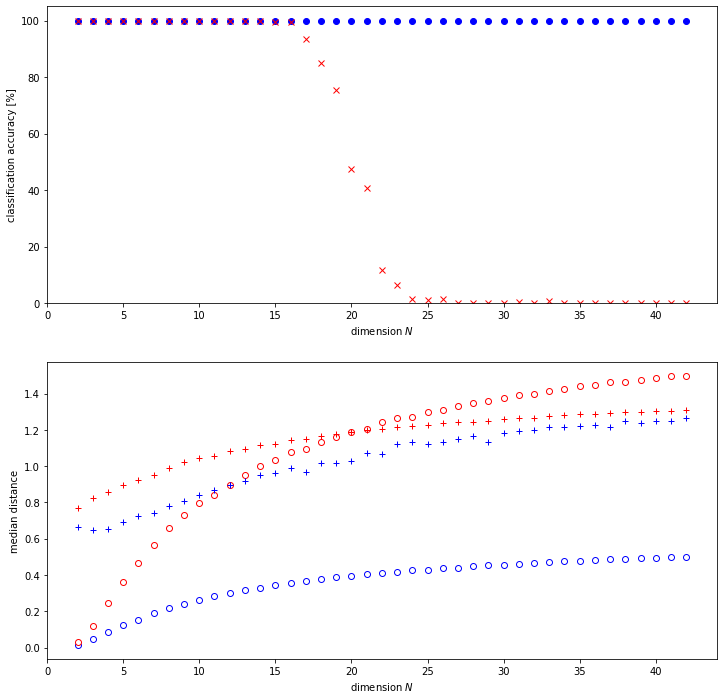

In [11]:
Nmax=42
fig,ax = plt.subplots(nrows=2, ncols=1,figsize=[12,12])

for N in np.arange(2,Nmax+1):
    
    Y0 = fDataGeneration(M,N,R=r0)
    Y1 = fDataGeneration(M,N,R=r1)
    BT0 = BallTree(Y0, leaf_size=5, p=2)
    BT1 = BallTree(Y1, leaf_size=5, p=2)
    
    nn_dist00 =np.sort(BT0.query(Y0, 2)[0][:, 1])
    nn_dist11 =np.sort(BT1.query(Y1, 2)[0][:, 1])
    nn_dist10 =np.sort(BT0.query(Y1, 2)[0][:, 0])
    nn_dist01 =np.sort(BT1.query(Y0, 2)[0][:, 0])
    
    ax[1].plot(N,np.median(nn_dist00), 'bo',markerfacecolor='w')
    ax[1].plot(N,np.median(nn_dist11), 'ro',markerfacecolor='w')
    ax[1].plot(N,np.median(nn_dist01), 'b+')
    ax[1].plot(N,np.median(nn_dist10), 'r+')
    
    F0 = np.sum((nn_dist00<nn_dist01)*1.0)/M
    F1 = np.sum((nn_dist11<nn_dist10)*1.0)/M
    ax[0].plot(N,F0*100, 'bo')
    ax[0].plot(N,F1*100, 'rx')
    
ax[0].set_xlabel('dimension $N$');
ax[0].set_ylabel('classification accuracy [%]');
ax[0].set_ylim([0,105]);
ax[1].set_xlabel('dimension $N$');
ax[1].set_ylabel('median distance');


## Take home message

I wanted to check whether the curse of dimensionality is also relevant when data is not sampled in a completely random fashion, e.g. when two data classes are separable despite high dimensionality. In the process, I learned:

* That the curse of dimensionality can affect certain classifiers even if the classes are (nonlinearly) separable

* That kNN classifiers perform worse as the number of dimensions increases in cases where the data of one or more classes do not live in a low-dimensional manifold

The next question is whether we can expect to build any good machine learning model at all for the studied example. There are three options available:

(a) knowledge-based feature engineering 

(b) an alternative model for classification. 

(c) collecting more data

Option (c) is unrealistic in many situations because the required number of samples and computational effort increases exponentially, which makes rendering this approach useless pretty quickly. Option (a) is explored in the [next post](curse2.ipynb). Option (b) in [the one after](curse3.ipynb).
